# Classical Search Algorithms for the Sokoban Puzzle

This notebook implements and analyzes classical search algorithms applied to the **Sokoban** puzzle. We will model Sokoban as a formal search problem and solve it using BFS, DFS, UCS, Greedy Best-First Search, and A\*.

### What is Sokoban?
**Sokoban** (Japanese for "warehouse keeper") is a classic combinatorial puzzle. A player moves on a grid and must push boxes onto designated goal locations. The player can move in four cardinal directions (Up, Down, Left, Right) and can push but never pull one box at a time. The puzzle is solved when every box rests on a goal square.

Sokoban is known to be **PSPACE-complete**, making it an excellent benchmark for evaluating search algorithms.

In [3]:
#symbols for different type
WALL   = '#'
FLOOR  = ' '
PLAYER = '@'
BOX    = '$'
GOAL   = '.'
PLAYER_ON_GOAL = '+'
BOX_ON_GOAL    = '*'

#Small Sokoban level(7rows × 7cols, 2 boxes)
LEVEL = [
    "#######",
    "#  .  #",
    "#     #",
    "# $@$ #",
    "#     #",
    "#  .  #",
    "#######",
]
def print_grid(grid):
    """Pretty-print a Sokoban grid with row/col indices."""
    cols = len(grid[0])
    # Column header
    header = '   ' + ''.join(str(c) for c in range(cols))
    print(header)
    print('   ' + '-' * cols)
    for r, row in enumerate(grid):
        print(f'{r} | {row}')
    print()
print('Sokoban Level (7×7, 2 boxes, 2 goals):')
print()
print_grid(LEVEL)

Sokoban Level (7×7, 2 boxes, 2 goals):

   0123456
   -------
0 | #######
1 | #  .  #
2 | #     #
3 | # $@$ #
4 | #     #
5 | #  .  #
6 | #######



In [4]:
#State Extraction
def parse_level(level):
    """Parse a Sokoban level grid and extract all components.

    Parameters
    ----------
    level : list[str]
        The grid representation of the level.

    Returns
    -------
    walls  : frozenset of (row, col)
    goals  : frozenset of (row, col)
    boxes  : frozenset of (row, col)
    player : (row, col)
    """
    walls  = set()
    goals  = set()
    boxes  = set()
    player = None

    for r, row in enumerate(level):
        for c, ch in enumerate(row):
            if ch == WALL:
                walls.add((r, c))
            elif ch == PLAYER:
                player = (r, c)
            elif ch == BOX:
                boxes.add((r, c))
            elif ch == GOAL:
                goals.add((r, c))
            elif ch == PLAYER_ON_GOAL:
                player = (r, c)
                goals.add((r, c))
            elif ch == BOX_ON_GOAL:
                boxes.add((r, c))
                goals.add((r, c))

    return frozenset(walls), frozenset(goals), frozenset(boxes), player


def initial_state(level):
    """Return the initial search state from a level.

    Returns
    -------
    state : (player_pos, frozenset_of_box_positions)
    walls : frozenset
    goals : frozenset
    """
    walls, goals, boxes, player = parse_level(level)
    return (player, boxes), walls, goals


#extract and display components
walls, goals, boxes, player = parse_level(LEVEL)

print('Player position :', player)
print('Box positions   :', sorted(boxes))
print('Goal positions  :', sorted(goals))
print('Number of walls :', len(walls))
print()

#build the search state
state0, WALLS, GOALS = initial_state(LEVEL)
print('Initial state   :', state0)
print('State is hashable:', hash(state0) is not None)

Player position : (3, 3)
Box positions   : [(3, 2), (3, 4)]
Goal positions  : [(1, 3), (5, 3)]
Number of walls : 24

Initial state   : ((3, 3), frozenset({(3, 2), (3, 4)}))
State is hashable: True


In [5]:
#Legal Move Generator (Transition Model)


#Direction vectors
DIRECTIONS = {
    'UP':    (-1,  0),
    'DOWN':  ( 1,  0),
    'LEFT':  ( 0, -1),
    'RIGHT': ( 0,  1),
}


def get_successors(state, walls):
    """Generate all valid successor states from the current state.

    Parameters
    ----------
    state : (player_pos, frozenset_of_box_positions)
    walls : frozenset of (row, col)

    Yields
    ------
    (new_state, action_name, step_cost)
        new_state : (new_player_pos, new_box_positions)
        action_name : str  — one of 'UP', 'DOWN', 'LEFT', 'RIGHT'
        step_cost : int    — always 1
    """
    player, boxes = state
    pr, pc = player

    for action, (dr, dc) in DIRECTIONS.items():
        #Target cell the player wants to move into
        tr, tc = pr + dr, pc + dc
        target = (tr, tc)

        #1. Wall check
        if target in walls:
            continue

        #2. Box push check
        if target in boxes:
            # Cell beyond the box
            br, bc = tr + dr, tc + dc
            beyond = (br, bc)

            #Cannot push if beyond is wall or another box
            if beyond in walls or beyond in boxes:
                continue

            #Push succeeds update box positions
            new_boxes = (boxes - {target}) | {beyond}
            new_state = (target, new_boxes)
            yield new_state, action, 1

        else:
            # 3. Simple move (empty cell)
            new_state = (target, boxes)
            yield new_state, action, 1


#Test: successors from the initial state
state0, WALLS, GOALS = initial_state(LEVEL)
print('Initial state:', state0)
print()

print('Legal moves from initial state:')
print('-' * 50)
for successor, action, cost in get_successors(state0, WALLS):
    player_new, boxes_new = successor
    print(f'  Action: {action:5s}  |  New player pos: {player_new}  |  Boxes: {sorted(boxes_new)}  |  Cost: {cost}')

print()
print(f'Total legal moves: {sum(1 for _ in get_successors(state0, WALLS))}')

Initial state: ((3, 3), frozenset({(3, 2), (3, 4)}))

Legal moves from initial state:
--------------------------------------------------
  Action: UP     |  New player pos: (2, 3)  |  Boxes: [(3, 2), (3, 4)]  |  Cost: 1
  Action: DOWN   |  New player pos: (4, 3)  |  Boxes: [(3, 2), (3, 4)]  |  Cost: 1
  Action: LEFT   |  New player pos: (3, 2)  |  Boxes: [(3, 1), (3, 4)]  |  Cost: 1
  Action: RIGHT  |  New player pos: (3, 4)  |  Boxes: [(3, 2), (3, 5)]  |  Cost: 1

Total legal moves: 4


In [6]:
#Goal Test

def is_goal(state, goals):
    """Return True if all boxes are on goal positions.

    Parameters
    ----------
    state : (player_pos, frozenset_of_box_positions)
    goals : frozenset of (row, col)
    """
    _, boxes = state
    return boxes == goals


#Test the goal function
state0, WALLS, GOALS = initial_state(LEVEL)

#Initial state should NOT be a goal
print('Initial state is goal?', is_goal(state0, GOALS))

#Manually create a goal state for testing
goal_state = (state0[0], GOALS)  # pretend boxes are on goals
print('Fake goal state is goal?', is_goal(goal_state, GOALS))

Initial state is goal? False
Fake goal state is goal? True


In [7]:
#BFS (Breadth-First Search)

from collections import deque
import time


def bfs(level):
    """Breadth-First Search for Sokoban.

    Returns
    -------
    path : list of action strings, or None if no solution
    nodes_expanded : int
    elapsed : float (seconds)
    """
    state0, walls, goals = initial_state(level)
    if is_goal(state0, goals):
        return [], 0, 0.0

    frontier = deque()
    frontier.append((state0, []))   # (state, path)
    visited = {state0}
    nodes_expanded = 0

    start = time.time()

    while frontier:
        state, path = frontier.popleft()
        nodes_expanded += 1

        for successor, action, cost in get_successors(state, walls):
            if successor in visited:
                continue
            new_path = path + [action]
            if is_goal(successor, goals):
                return new_path, nodes_expanded, time.time() - start
            visited.add(successor)
            frontier.append((successor, new_path))

    return None, nodes_expanded, time.time() - start


#Test BFS on our level
path, expanded, elapsed = bfs(LEVEL)
print('=== BFS Results ===')
print(f'Solution found : {path is not None}')
print(f'Path length    : {len(path) if path else "N/A"}')
print(f'Solution       : {path}')
print(f'Nodes expanded : {expanded}')
print(f'Time (s)       : {elapsed:.4f}')

=== BFS Results ===
Solution found : True
Path length    : 15
Solution       : ['UP', 'LEFT', 'DOWN', 'DOWN', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'UP', 'UP', 'RIGHT', 'UP', 'LEFT']
Nodes expanded : 4309
Time (s)       : 0.0167


In [8]:
#DFS (Depth-First Search) with Depth Limit


def dfs(level, depth_limit=200):
    """Depth-First Search for Sokoban with an optional depth limit.

    Parameters
    ----------
    level : list[str]
    depth_limit : int
        Maximum depth to explore (prevents infinite loops).

    Returns
    -------
    path : list of action strings, or None
    nodes_expanded : int
    elapsed : float
    """
    state0, walls, goals = initial_state(level)
    if is_goal(state0, goals):
        return [], 0, 0.0

    stack = [(state0, [])]   # (state, path)
    visited = {state0}
    nodes_expanded = 0

    start = time.time()

    while stack:
        state, path = stack.pop()
        nodes_expanded += 1

        if len(path) >= depth_limit:
            continue

        for successor, action, cost in get_successors(state, walls):
            if successor in visited:
                continue
            new_path = path + [action]
            if is_goal(successor, goals):
                return new_path, nodes_expanded, time.time() - start
            visited.add(successor)
            stack.append((successor, new_path))

    return None, nodes_expanded, time.time() - start


#Test DFS on our level
path_dfs, expanded_dfs, elapsed_dfs = dfs(LEVEL)
print('=== DFS Results ===')
print(f'Solution found : {path_dfs is not None}')
print(f'Path length    : {len(path_dfs) if path_dfs else "N/A"}')
print(f'Solution       : {path_dfs}')
print(f'Nodes expanded : {expanded_dfs}')
print(f'Time (s)       : {elapsed_dfs:.4f}')
print()
print('--- Comparison with BFS ---')
path_bfs, expanded_bfs, elapsed_bfs = bfs(LEVEL)
print(f'BFS path length: {len(path_bfs) if path_bfs else "N/A"}  |  DFS path length: {len(path_dfs) if path_dfs else "N/A"}')
print(f'BFS nodes     : {expanded_bfs}  |  DFS nodes     : {expanded_dfs}')

=== DFS Results ===
Solution found : True
Path length    : 199
Solution       : ['DOWN', 'RIGHT', 'RIGHT', 'UP', 'LEFT', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'UP', 'UP', 'UP', 'RIGHT', 'RIGHT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'UP', 'UP', 'RIGHT', 'RIGHT', 'LEFT', 'LEFT', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'UP', 'UP', 'LEFT', 'DOWN', 'LEFT', 'RIGHT', 'RIGHT', 'UP', 'UP', 'LEFT', 'LEFT', 'DOWN', 'LEFT', 'DOWN', 'RIGHT', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'LEFT', 'LEFT', 'UP', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'LEFT', 'RIGHT', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'UP', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'DOWN', 'LEFT', 'RIGHT', 'UP', 'UP', 'LEFT', 'LEFT', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'RIGHT', 'RIGHT', 'UP', 'UP', 'LEFT', 'LEFT', 'UP', 'LEFT', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'LEFT', 'LEFT', 'DOWN', 'DOWN', 'RIGHT', 'RI

In [9]:
#UCS (Uniform Cost Search)

import heapq


def ucs(level):
    """Uniform Cost Search for Sokoban.

    Returns
    -------
    path : list of action strings, or None
    nodes_expanded : int
    elapsed : float
    """
    state0, walls, goals = initial_state(level)
    if is_goal(state0, goals):
        return [], 0, 0.0

    # Priority queue: (cumulative_cost, tie_breaker, state, path)
    counter = 0
    frontier = []
    heapq.heappush(frontier, (0, counter, state0, []))
    visited = set()
    nodes_expanded = 0

    start = time.time()

    while frontier:
        g, _, state, path = heapq.heappop(frontier)

        if state in visited:
            continue
        visited.add(state)
        nodes_expanded += 1

        if is_goal(state, goals):
            return path, nodes_expanded, time.time() - start

        for successor, action, cost in get_successors(state, walls):
            if successor not in visited:
                counter += 1
                heapq.heappush(frontier, (g + cost, counter, successor, path + [action]))

    return None, nodes_expanded, time.time() - start


#Test UCS 
path_ucs, expanded_ucs, elapsed_ucs = ucs(LEVEL)
print('=== UCS Results ===')
print(f'Solution found : {path_ucs is not None}')
print(f'Path length    : {len(path_ucs) if path_ucs else "N/A"}')
print(f'Solution       : {path_ucs}')
print(f'Nodes expanded : {expanded_ucs}')
print(f'Time (s)       : {elapsed_ucs:.4f}')

=== UCS Results ===
Solution found : True
Path length    : 15
Solution       : ['UP', 'LEFT', 'DOWN', 'DOWN', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'UP', 'UP', 'RIGHT', 'UP', 'LEFT']
Nodes expanded : 5223
Time (s)       : 0.0230


In [10]:

#Heuristic Function (Manhattan Distance)


def manhattan_heuristic(state, goals):
    """Sum of minimum Manhattan distances from each box to nearest goal.

    Parameters
    ----------
    state : (player_pos, frozenset_of_box_positions)
    goals : frozenset of (row, col)

    Returns
    -------
    int : admissible heuristic value
    """
    _, boxes = state
    total = 0
    for br, bc in boxes:
        min_dist = min(abs(br - gr) + abs(bc - gc) for gr, gc in goals)
        total += min_dist
    return total


# --- Test the heuristic ----------------------------------------
state0, WALLS, GOALS = initial_state(LEVEL)
h0 = manhattan_heuristic(state0, GOALS)
print(f'Initial state heuristic h(s0) = {h0}')
print(f'Boxes : {sorted(state0[1])}')
print(f'Goals : {sorted(GOALS)}')
print()

# Test on goal state (should be 0)
goal_state = (state0[0], GOALS)
print(f'Goal state heuristic h(goal) = {manhattan_heuristic(goal_state, GOALS)}')

Initial state heuristic h(s0) = 6
Boxes : [(3, 2), (3, 4)]
Goals : [(1, 3), (5, 3)]

Goal state heuristic h(goal) = 0


In [11]:

#Greedy Best-First Search


def greedy_bfs(level):
    """Greedy Best-First Search using Manhattan heuristic.

    Returns
    -------
    path : list of action strings, or None
    nodes_expanded : int
    elapsed : float
    """
    state0, walls, goals = initial_state(level)
    if is_goal(state0, goals):
        return [], 0, 0.0

    counter = 0
    frontier = []
    h0 = manhattan_heuristic(state0, goals)
    heapq.heappush(frontier, (h0, counter, state0, []))
    visited = set()
    nodes_expanded = 0

    start = time.time()

    while frontier:
        _, _, state, path = heapq.heappop(frontier)

        if state in visited:
            continue
        visited.add(state)
        nodes_expanded += 1

        if is_goal(state, goals):
            return path, nodes_expanded, time.time() - start

        for successor, action, cost in get_successors(state, walls):
            if successor not in visited:
                h = manhattan_heuristic(successor, goals)
                counter += 1
                heapq.heappush(frontier, (h, counter, successor, path + [action]))

    return None, nodes_expanded, time.time() - start


# --- Test Greedy BFS -------------------------------------------
path_gbfs, expanded_gbfs, elapsed_gbfs = greedy_bfs(LEVEL)
print('=== Greedy Best-First Search Results ===')
print(f'Solution found : {path_gbfs is not None}')
print(f'Path length    : {len(path_gbfs) if path_gbfs else "N/A"}')
print(f'Solution       : {path_gbfs}')
print(f'Nodes expanded : {expanded_gbfs}')
print(f'Time (s)       : {elapsed_gbfs:.4f}')

=== Greedy Best-First Search Results ===
Solution found : True
Path length    : 15
Solution       : ['UP', 'LEFT', 'DOWN', 'DOWN', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'UP', 'UP', 'RIGHT', 'UP', 'LEFT']
Nodes expanded : 36
Time (s)       : 0.0002


In [12]:

#A* Search


def a_star(level):
    """A* Search using Manhattan heuristic.

    Returns
    -------
    path : list of action strings, or None
    total_cost : int
    nodes_expanded : int
    elapsed : float
    """
    state0, walls, goals = initial_state(level)
    if is_goal(state0, goals):
        return [], 0, 0, 0.0

    counter = 0
    h0 = manhattan_heuristic(state0, goals)
    # (f, tie_breaker, g, state, path)
    frontier = []
    heapq.heappush(frontier, (h0, counter, 0, state0, []))
    visited = set()
    nodes_expanded = 0

    start = time.time()

    while frontier:
        f, _, g, state, path = heapq.heappop(frontier)

        if state in visited:
            continue
        visited.add(state)
        nodes_expanded += 1

        if is_goal(state, goals):
            return path, g, nodes_expanded, time.time() - start

        for successor, action, cost in get_successors(state, walls):
            if successor not in visited:
                new_g = g + cost
                h = manhattan_heuristic(successor, goals)
                counter += 1
                heapq.heappush(frontier, (new_g + h, counter, new_g, successor, path + [action]))

    return None, float('inf'), nodes_expanded, time.time() - start


# --- Test A* ---------------------------------------------------
path_astar, cost_astar, expanded_astar, elapsed_astar = a_star(LEVEL)
print('=== A* Search Results ===')
print(f'Solution found : {path_astar is not None}')
print(f'Path length    : {len(path_astar) if path_astar else "N/A"}')
print(f'Total cost     : {cost_astar}')
print(f'Solution       : {path_astar}')
print(f'Nodes expanded : {expanded_astar}')
print(f'Time (s)       : {elapsed_astar:.4f}')

=== A* Search Results ===
Solution found : True
Path length    : 15
Total cost     : 15
Solution       : ['UP', 'LEFT', 'DOWN', 'DOWN', 'LEFT', 'DOWN', 'RIGHT', 'UP', 'RIGHT', 'RIGHT', 'UP', 'UP', 'RIGHT', 'UP', 'LEFT']
Nodes expanded : 2465
Time (s)       : 0.0233


In [14]:
#Evaluating Performance

import pandas as pd


results = []

# BFS
p, n, t = bfs(LEVEL)
results.append({'Algorithm': 'BFS', 'Path Length': len(p) if p else None,
                'Nodes Expanded': n, 'Time (s)': round(t, 6),
                'Optimal': 'Yes', 'Complete': 'Yes'})

# DFS
p, n, t = dfs(LEVEL)
results.append({'Algorithm': 'DFS', 'Path Length': len(p) if p else None,
                'Nodes Expanded': n, 'Time (s)': round(t, 6),
                'Optimal': 'No', 'Complete': 'No*'})

# UCS
p, n, t = ucs(LEVEL)
results.append({'Algorithm': 'UCS', 'Path Length': len(p) if p else None,
                'Nodes Expanded': n, 'Time (s)': round(t, 6),
                'Optimal': 'Yes', 'Complete': 'Yes'})

# Greedy BFS
p, n, t = greedy_bfs(LEVEL)
results.append({'Algorithm': 'Greedy BFS', 'Path Length': len(p) if p else None,
                'Nodes Expanded': n, 'Time (s)': round(t, 6),
                'Optimal': 'No', 'Complete': 'No'})

# A*
p, cost, n, t = a_star(LEVEL)
results.append({'Algorithm': 'A*', 'Path Length': len(p) if p else None,
                'Nodes Expanded': n, 'Time (s)': round(t, 6),
                'Optimal': 'Yes', 'Complete': 'Yes'})


df = pd.DataFrame(results)
df = df[['Algorithm', 'Path Length', 'Nodes Expanded', 'Time (s)', 'Optimal', 'Complete']]
print('=' * 70)
print('            PERFORMANCE COMPARISON TABLE')
print('=' * 70)
print(df.to_string(index=False))
print()
print('* DFS completeness depends on depth limit.')

            PERFORMANCE COMPARISON TABLE
 Algorithm  Path Length  Nodes Expanded  Time (s) Optimal Complete
       BFS           15            4309  0.094651     Yes      Yes
       DFS          199            4927  0.012571      No      No*
       UCS           15            5223  0.020785     Yes      Yes
Greedy BFS           15              36  0.000198      No       No
        A*           15            2465  0.013979     Yes      Yes

* DFS completeness depends on depth limit.


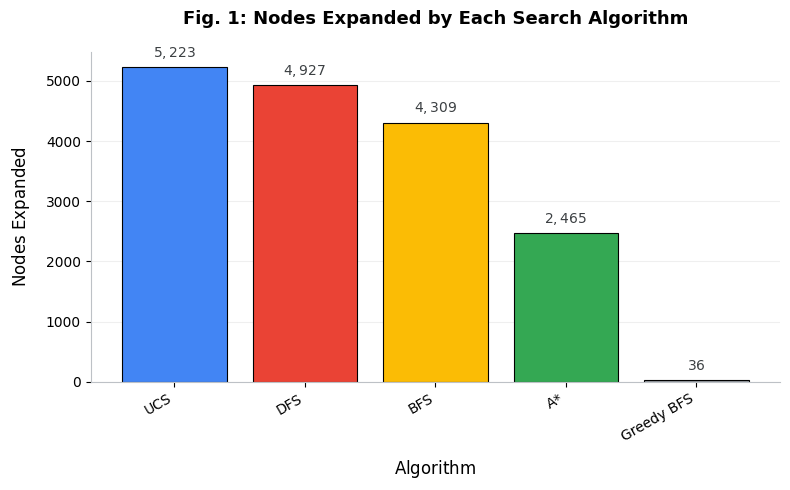

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df is already defined with 'Algorithm' and 'Nodes Expanded'
# 1. Sort the dataframe for logical flow (highest to lowest)
df = df.sort_values(by='Nodes Expanded', ascending=False)

algorithms = df['Algorithm'].tolist()
nodes = df['Nodes Expanded'].tolist()

# 2. Google Style Color Palette (Blue, Red, Yellow, Green, Grey)
google_colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853', '#9AA0A6']

fig, ax = plt.subplots(figsize=(8, 5))

# Ensure color list repeats if there are more than 5 algorithms
bars = ax.bar(algorithms, nodes, color=google_colors[:len(algorithms)], 
              edgecolor='black', linewidth=0.8)

# 3. Add value labels with padding to ensure no overlap
max_val = max(nodes)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + (max_val * 0.02),
            f'${int(height):,}$', ha='center', va='bottom', 
            fontweight='bold', fontsize=10, color='#3c4043')

# 4. Publication-grade labels using LaTeX formatting
ax.set_xlabel(r'$\mathrm{Algorithm}$', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel(r'$\mathrm{Nodes \ Expanded}$', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('Fig. 1: Nodes Expanded by Each Search Algorithm', 
             fontsize=13, fontweight='bold', pad=20)

# 5. Prevent label overlap (Rotate and align)
plt.xticks(rotation=30, ha='right', fontsize=10)

# 6. Refined Aesthetics
ax.grid(axis='y', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)

# Remove chart junk
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc1c6')
ax.spines['bottom'].set_color('#bdc1c6')

plt.tight_layout()
plt.savefig('google_style_nodes.png', dpi=300, bbox_inches='tight')
plt.show()

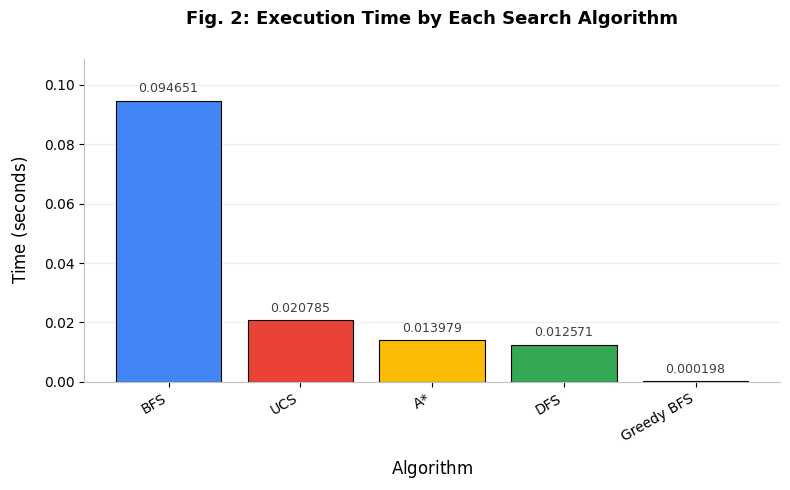

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Sort the dataframe (keeping the 'descent' logic from before)
# It's usually best to sort by the metric being measured
df_time = df.sort_values(by='Time (s)', ascending=False)

algorithms = df_time['Algorithm'].tolist()
times = df_time['Time (s)'].tolist()

# 2. Google Brand Palette
google_colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853', '#9AA0A6']

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(algorithms, times, color=google_colors[:len(algorithms)], 
              edgecolor='black', linewidth=0.8)

# 3. Add high-precision value labels (ensure no overlap)
max_time = max(times) if times else 1
for bar, val in zip(bars, times):
    # Dynamic padding: 2% of the max value
    padding = max_time * 0.02
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + padding,
            f'${val:.6f}$', ha='center', va='bottom', 
            fontweight='bold', fontsize=9, color='#3c4043')

# 4. Axis labels and title with LaTeX formatting
ax.set_xlabel(r'$\mathrm{Algorithm}$', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel(r'$\mathrm{Time \ (seconds)}$', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('Fig. 2: Execution Time by Each Search Algorithm', 
             fontsize=13, fontweight='bold', pad=25)

# 5. Prevent label overlap (30-degree rotation is standard for publications)
plt.xticks(rotation=30, ha='right', fontsize=10)

# 6. Professional Aesthetics
ax.grid(axis='y', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)

# Clean up the frame (Google/Publication style)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc1c6')
ax.spines['bottom'].set_color('#bdc1c6')

# Adjust y-limit to give room for labels
ax.set_ylim(0, max_time * 1.15)

plt.tight_layout()
plt.savefig('fig2_execution_time.png', dpi=300, bbox_inches='tight')
plt.show()

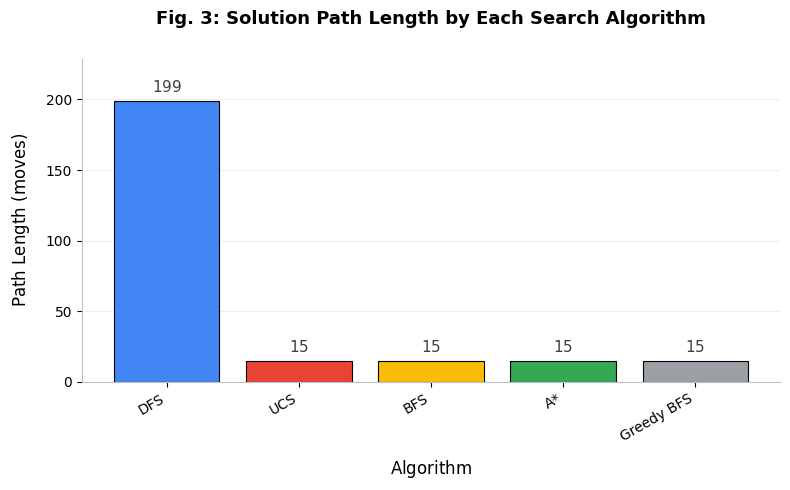

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Sort the dataframe by Path Length (Descending/Descent order)
df_path = df.sort_values(by='Path Length', ascending=False)

algorithms = df_path['Algorithm'].tolist()
path_lengths = df_path['Path Length'].tolist()

# 2. Google Brand Palette (Blue, Red, Yellow, Green, Grey)
google_colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853', '#9AA0A6']

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(algorithms, path_lengths, color=google_colors[:len(algorithms)], 
              edgecolor='black', linewidth=0.8)

# 3. Add integer value labels with padding (ensures no overlap)
max_len = max(path_lengths) if path_lengths else 1
for bar in bars:
    height = bar.get_height()
    # 2% padding for visual breathing room
    ax.text(bar.get_x() + bar.get_width() / 2, height + (max_len * 0.02),
            f'${int(height):,}$', ha='center', va='bottom', 
            fontweight='bold', fontsize=11, color='#3c4043')

# 4. Axis labels and title with LaTeX-style formatting
ax.set_xlabel(r'$\mathrm{Algorithm}$', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel(r'$\mathrm{Path \ Length \ (moves)}$', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('Fig. 3: Solution Path Length by Each Search Algorithm', 
             fontsize=13, fontweight='bold', pad=25)

# 5. Prevent label overlap (consistent 30-degree rotation)
plt.xticks(rotation=30, ha='right', fontsize=10)

# 6. Final Professional Aesthetics
ax.grid(axis='y', alpha=0.2, linestyle='-')
ax.set_axisbelow(True)

# Clean up chart borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc1c6')
ax.spines['bottom'].set_color('#bdc1c6')

# Give the y-axis some "headroom" for the labels
ax.set_ylim(0, max_len * 1.15)

plt.tight_layout()
plt.savefig('fig3_path_length.png', dpi=300, bbox_inches='tight')
plt.show()

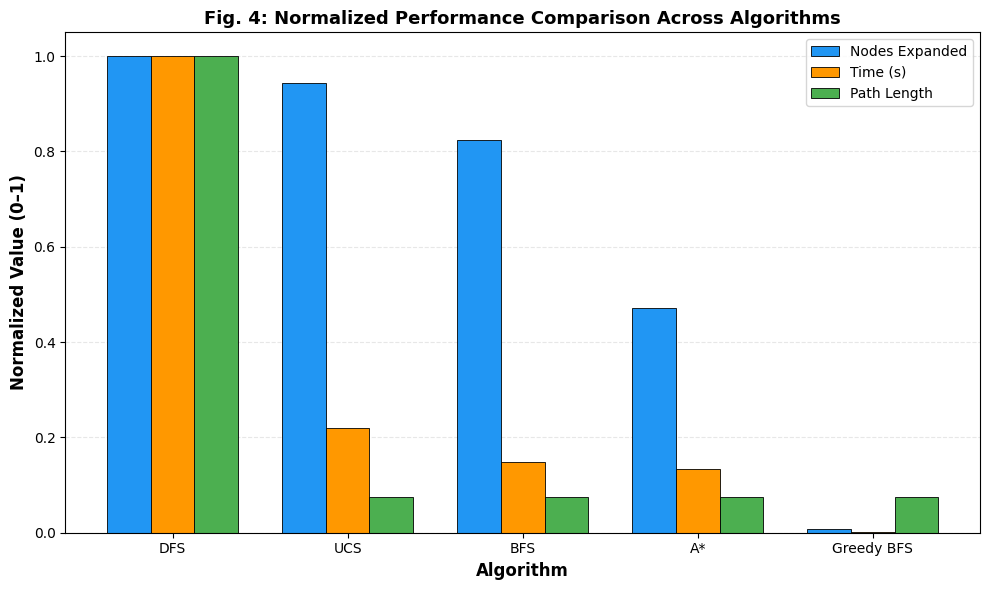

In [41]:
#Grouped Bar Chart (Normalized Metrics)

# Normalize each metric to [0, 1] for visual comparison
nodes_arr = np.array(nodes, dtype=float)
times_arr = np.array(times, dtype=float)
paths_arr = np.array(path_lengths, dtype=float)

def normalize(arr):
    mx = arr.max()
    return arr / mx if mx > 0 else arr

nodes_norm = normalize(nodes_arr)
times_norm = normalize(times_arr)
paths_norm = normalize(paths_arr)

x = np.arange(len(algorithms))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, nodes_norm, width, label='Nodes Expanded', color='#2196F3', edgecolor='black', linewidth=0.6)
bar2 = ax.bar(x,         times_norm, width, label='Time (s)',        color='#FF9800', edgecolor='black', linewidth=0.6)
bar3 = ax.bar(x + width, paths_norm, width, label='Path Length',     color='#4CAF50', edgecolor='black', linewidth=0.6)

ax.set_xlabel('Algorithm', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Value (0–1)', fontsize=12, fontweight='bold')
ax.set_title('Fig. 4: Normalized Performance Comparison Across Algorithms', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('fig4_grouped_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


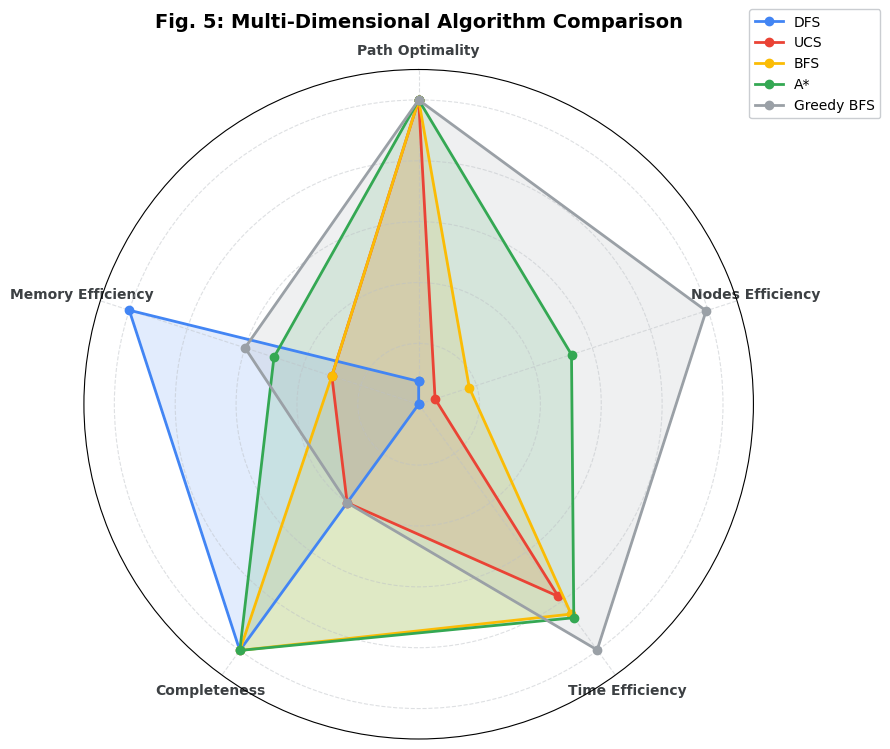

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Define Categories and Angles
categories = ['Path Optimality', 'Nodes Efficiency', 'Time Efficiency',
              'Completeness', 'Memory Efficiency']
N = len(categories)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

# 2. Score Logic (Ensuring higher = better for the visual)
# Assuming 'algorithms', 'path_lengths', 'nodes_norm', and 'times_norm' are pre-defined
best_path = min(path_lengths)
algo_scores = {}

for i, alg in enumerate(algorithms):
    path_opt = best_path / path_lengths[i] if path_lengths[i] > 0 else 0
    node_eff = 1.0 - nodes_norm[i]
    time_eff = 1.0 - times_norm[i]
    
    # Check if 'Complete' column exists, otherwise default to high
    try:
        is_complete = df.iloc[i]['Complete']
        complete = 1.0 if (is_complete == 'Yes' or is_complete is True) else 0.4
    except:
        complete = 1.0 

    mem_scores = {'BFS': 0.3, 'DFS': 1.0, 'UCS': 0.3, 'Greedy BFS': 0.6, 'A* Search': 0.6}
    mem_eff = mem_scores.get(alg, 0.5)
    
    algo_scores[alg] = [path_opt, node_eff, time_eff, complete, mem_eff]

# 3. Plotting with Google Brand Palette
google_colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853', '#9AA0A6']

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

for i, (alg, scores) in enumerate(algo_scores.items()):
    values = scores + scores[:1]
    color = google_colors[i % len(google_colors)]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=alg, color=color, markersize=6)
    ax.fill(angles, values, alpha=0.15, color=color)

# 4. Axis and Label Formatting
ax.set_theta_offset(np.pi / 2)  # Put the first category at the top
ax.set_theta_direction(-1)      # Draw clockwise

# Add labels with increased padding to prevent overlap
ax.set_thetagrids([a * 180/np.pi for a in angles[:-1]], categories, 
                   fontsize=10, fontweight='bold', color='#3c4043')

# Soften the radial grid
ax.set_ylim(0, 1.1)
ax.set_yticklabels([]) # Clean look: remove radial numbers
ax.grid(color='#bdc1c6', linestyle='--', alpha=0.5)

# 5. Legend and Title
ax.set_title('Fig. 5: Multi-Dimensional Algorithm Comparison', 
             fontsize=14, fontweight='bold', pad=30)

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), 
          fontsize=10, frameon=True, edgecolor='#bdc1c6')

plt.tight_layout()
plt.savefig('fig5_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

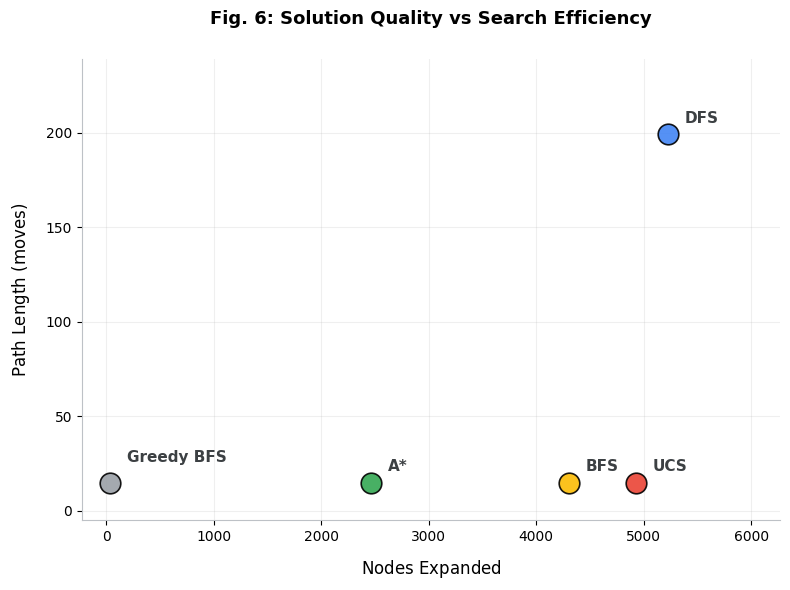

In [51]:
import matplotlib.pyplot as plt

# 1. Define the Google Brand Palette (5 colors)
google_colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853', '#9AA0A6']

fig, ax = plt.subplots(figsize=(8, 6))

for i, alg in enumerate(algorithms):
    # Use modulo (%) to prevent IndexError if i > 4
    current_color = google_colors[i % len(google_colors)]
    
    # Using your actual data: nodes and path_lengths
    ax.scatter(nodes[i], path_lengths[i], color=current_color, s=220,
               edgecolors='black', linewidths=1.2, zorder=5, alpha=0.9)
    
    # 2. Annotation with logic to prevent overlap
    # If the algorithm is A* or Greedy (usually low nodes), we nudge the text
    x_offset, y_offset = 12, 8
    if nodes[i] < (max(nodes) * 0.1): 
        y_offset = 15 if i % 2 == 0 else -20
    
    ax.annotate(alg, (nodes[i], path_lengths[i]),
                textcoords='offset points', xytext=(x_offset, y_offset),
                fontsize=11, fontweight='bold', color='#3c4043')

# 3. Publication-grade formatting (LaTeX style)
ax.set_xlabel(r'$\mathrm{Nodes \ Expanded}$', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel(r'$\mathrm{Path \ Length \ (moves)}$', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('Fig. 6: Solution Quality vs Search Efficiency', fontsize=13, fontweight='bold', pad=25)

# 4. Professional Aesthetics
ax.grid(alpha=0.2, linestyle='-', zorder=1)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc1c6')
ax.spines['bottom'].set_color('#bdc1c6')

# Ensure enough margin so labels aren't cut off
ax.set_xlim(min(nodes) - (max(nodes)*0.05), max(nodes) * 1.2)
ax.set_ylim(min(path_lengths) - 20, max(path_lengths) + 40)

plt.tight_layout()
plt.savefig('fig6_scatter_quality_vs_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

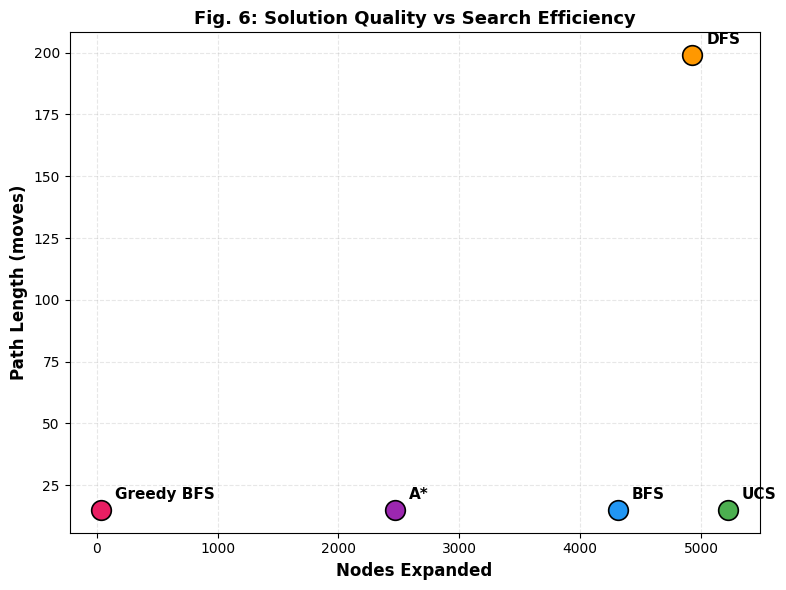

In [32]:
#Scatter Plot: Path Length vs Nodes Expanded


fig, ax = plt.subplots(figsize=(8, 6))

for i, alg in enumerate(algorithms):
    ax.scatter(nodes[i], path_lengths[i], color=colors[i], s=200,
               edgecolors='black', linewidths=1.2, zorder=5)
    ax.annotate(alg, (nodes[i], path_lengths[i]),
                textcoords='offset points', xytext=(10, 8),
                fontsize=11, fontweight='bold')

ax.set_xlabel('Nodes Expanded', fontsize=12, fontweight='bold')
ax.set_ylabel('Path Length (moves)', fontsize=12, fontweight='bold')
ax.set_title('Fig. 6: Solution Quality vs Search Efficiency', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('fig6_scatter_quality_vs_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()


In [48]:
#Results DataFrame


# Display the full results table with all columns
print('\nTable 1: Experimental Results Summary')
print('=' * 100)
display_df = df.copy()
display_df.index = range(1, len(display_df) + 1)
display_df.index.name = '#'
print(display_df.to_string())
print('=' * 100)
print()

# Also display as styled HTML (renders nicely in Jupyter/Kaggle)
try:
    from IPython.display import display, HTML
    styled = display_df.style.set_caption('Table 1: Experimental Results Summary') \
        .set_properties(**{'text-align': 'center', 'border': '1px solid black'}) \
        .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center'),
                           ('background-color', '#2196F3'), ('color', 'white'),
                           ('font-weight', 'bold')]},
                          {'selector': 'caption', 'props': [('font-size', '14px'),
                           ('font-weight', 'bold'), ('text-align', 'center')]}])
    display(styled)
except ImportError:
    pass



Table 1: Experimental Results Summary
    Algorithm  Path Length  Nodes Expanded  Time (s) Optimal Complete
#                                                                    
1         UCS           15            5223  0.020785     Yes      Yes
2         DFS          199            4927  0.012571      No      No*
3         BFS           15            4309  0.094651     Yes      Yes
4          A*           15            2465  0.013979     Yes      Yes
5  Greedy BFS           15              36  0.000198      No       No



,Algorithm,Path Length,Nodes Expanded,Time (s),Optimal,Complete
#,,,,,,
1,UCS,15,5223,0.020785,Yes,Yes
2,DFS,199,4927,0.012571,No,No*
3,BFS,15,4309,0.094651,Yes,Yes
4,A*,15,2465,0.013979,Yes,Yes
5,Greedy BFS,15,36,0.000198,No,No
